#Marge datasets and make big training dataset

In [31]:
import numpy as np # linear algebra
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
import os
print(os.listdir("../input"))

['test.csv', 'mulliken_charges.csv', 'dipole_moments.csv', 'train.csv', 'structures.csv', 'magnetic_shielding_tensors.csv', 'potential_energy.csv', 'sample_submission.csv', 'scalar_coupling_contributions.csv', 'structures']


In [32]:
#Load data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

#Load sub data
sub = pd.read_csv("../input/sample_submission.csv")
structures = pd.read_csv("../input/structures.csv")
scalar_coupling_contributions = pd.read_csv("../input/scalar_coupling_contributions.csv")
magnetic_shielding_tesors = pd.read_csv("../input/magnetic_shielding_tensors.csv")
dipole_moments = pd.read_csv("../input/dipole_moments.csv")
potential_energy = pd.read_csv("../input/potential_energy.csv")
mulliken_charges = pd.read_csv("../input/mulliken_charges.csv")

In [33]:
print(train.shape)
print(test.shape)
print(sub.shape)
print(structures.shape)
print(scalar_coupling_contributions.shape)
print(magnetic_shielding_tesors.shape)
print(dipole_moments.shape)
print(potential_energy.shape)
print(mulliken_charges.shape)

#check number of unique data 
print(train["molecule_name"].nunique())
print(test["molecule_name"].nunique())
print(structures["atom"].nunique())
print(train["type"].nunique())

(4658147, 6)
(2505542, 5)
(2505542, 2)
(2358657, 6)
(4658147, 8)
(1533537, 11)
(85003, 4)
(85003, 2)
(1533537, 3)
85003
45772
5
8


I want to marge dataset and add new features.

In [34]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

Now, marge 2 datasets!

In [35]:
train_structure = map_atom_info(train, 0)
train_structure = map_atom_info(train_structure, 1)

In [37]:
test_structure = map_atom_info(test, 0)
test_structure = map_atom_info(test_structure, 1)

OK, next let's calculate distunce of atoms.  
The distunce of atoms is sqrt((x_0 - x_1)^2 + (y_0 - y_1)^2 + (z_0 - z_1)^2), so I use numpy.linalg.norm.

In [39]:
train_p_0 = train_structure[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_structure[['x_1', 'y_1', 'z_1']].values
train_structure['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
#train_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277,H,-0.540815,1.447527,-0.876644,1.783158
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277,H,-0.523814,1.437933,0.906397,1.783148
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,H,-0.540815,1.447527,-0.876644,H,-0.523814,1.437933,0.906397,1.783148
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948


In [40]:
test_p_0 = test_structure[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_structure[['x_1', 'y_1', 'z_1']].values
test_structure['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
#test_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000,2.261178
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000,1.062099
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.000000,1.000000,H,1.661639,0.000000,1.000000,3.323277
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000,1.062099
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000,2.261178
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.005284,1.810158,0.004656,C,-0.014821,1.392412,0.005671,1.102328
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.005284,1.810158,0.004656,C,0.637949,-0.553297,-1.113582,2.640324
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.005284,1.810158,0.004656,H,-0.546896,1.793435,-0.872511,1.782964
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.005284,1.810158,0.004656,H,-0.530029,1.722920,0.911017,1.785017
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546896,1.793435,-0.872511,C,-0.014821,1.392412,0.005671,1.102327


Academically, atomic number become large, scalar coupling constant also become large.  
So, I want to add atomic number information in dataset.

In [41]:
train_structure["atomic_number_0"]=train_structure["atom_0"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)
train_structure["atomic_number_1"]=train_structure["atom_1"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)

In [43]:
test_structure["atomic_number_0"]=test_structure["atom_0"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)
test_structure["atomic_number_1"]=test_structure["atom_1"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)

In addition, maybe coupling number have effect for scalar coupling constant, let's add that.

In [45]:
train_structure["coupling_number_0"]=train_structure["atom_0"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)
train_structure["coupling_number_1"]=train_structure["atom_1"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)

In [46]:
test_structure["coupling_number_0"]=test_structure["atom_0"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)
test_structure["coupling_number_1"]=test_structure["atom_1"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)

In [47]:
test_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,atomic_number_0,atomic_number_1,coupling_number_0,coupling_number_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000,2.261178,1,6,1,4
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000,1.062099,1,6,1,4
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.000000,1.000000,H,1.661639,0.000000,1.000000,3.323277,1,1,1,1
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000,1.062099,1,6,1,4
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000,2.261178,1,6,1,4
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.005284,1.810158,0.004656,C,-0.014821,1.392412,0.005671,1.102328,1,6,1,4
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.005284,1.810158,0.004656,C,0.637949,-0.553297,-1.113582,2.640324,1,6,1,4
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.005284,1.810158,0.004656,H,-0.546896,1.793435,-0.872511,1.782964,1,1,1,1
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.005284,1.810158,0.004656,H,-0.530029,1.722920,0.911017,1.785017,1,1,1,1
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546896,1.793435,-0.872511,C,-0.014821,1.392412,0.005671,1.102327,1,6,1,4


#Get New features using by RDkit

Descripter and Fingerprint get from structure.xyz data.  

reference:  
https://www.kaggle.com/corochann/eda-and-graph-nn-baseline-modeling  
https://www.kaggle.com/corochann/visualize-molecules-with-rdkit  

##Prepare packages and functions

In [48]:
!pip install --quiet cupy-cuda100
!pip install --quiet chainer-chemistry
!pip install --quiet chaineripy
!conda install -y --quiet -c rdkit rdkit

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::statsmodels==0.9.0=py37h035aef0_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::h5py==2.8.0=py37h989c5e5_3
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::seaborn==0.9.0=py37_0
  - defaults/linux-64::imageio==2.4.1=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::scipy==1.1.0=py37hfa4b5c9_1
  - defaults/linux-64::anaconda==5.3.0=py37_0
  - defaults/linux-64::pywavelets==1

In [62]:
# Check correctly installed, and modules can be imported.
import chainer
import chainer_chemistry
import chaineripy
import cupy

print('chainer version: ', chainer.__version__)
print('cupy version: ', cupy.__version__)
print('chainer-chemistry version: ', chainer_chemistry.__version__)

from contextlib import contextmanager
import gc
from pathlib import Path
from time import time, perf_counter

import seaborn as sns
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset



chainer version:  6.1.0
cupy version:  6.1.0
chainer-chemistry version:  0.5.0


In [50]:
!conda install -y -c rdkit rdkit

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::statsmodels==0.9.0=py37h035aef0_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::h5py==2.8.0=py37h989c5e5_3
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::seaborn==0.9.0=py37_0
  - defaults/linux-64::imageio==2.4.1=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::scipy==1.1.0=py37hfa4b5c9_1
  - defaults/linux-64::anaconda==5.3.0=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37hdd

In [51]:
import rdkit
from rdkit import Chem

In [52]:
def timer(name):
    t0 = perf_counter()
    yield
    t1 = perf_counter()
    print('[{}] done in {:.3f} s'.format(name, t1-t0))

In [53]:
"""
Copied from
https://github.com/jensengroup/xyz2mol/blob/master/xyz2mol.py

Modified `chiral_stereo_check` method for this task's purpose.
"""
##
# Written by Jan H. Jensen based on this paper Yeonjoon Kim and Woo Youn Kim
# "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
# to Three-Dimensional Geometry" Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777 DOI: 10.1002/bkcs.10334
#
from rdkit.Chem import AllChem
import itertools
from rdkit.Chem import rdmolops
from collections import defaultdict
import copy
import networkx as nx  # uncomment if you don't want to use "quick"/install networkx

global __ATOM_LIST__
__ATOM_LIST__ = [x.strip() for x in ['h ', 'he', \
                                     'li', 'be', 'b ', 'c ', 'n ', 'o ', 'f ', 'ne', \
                                     'na', 'mg', 'al', 'si', 'p ', 's ', 'cl', 'ar', \
                                     'k ', 'ca', 'sc', 'ti', 'v ', 'cr', 'mn', 'fe', 'co', 'ni', 'cu', \
                                     'zn', 'ga', 'ge', 'as', 'se', 'br', 'kr', \
                                     'rb', 'sr', 'y ', 'zr', 'nb', 'mo', 'tc', 'ru', 'rh', 'pd', 'ag', \
                                     'cd', 'in', 'sn', 'sb', 'te', 'i ', 'xe', \
                                     'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'pm', 'sm', 'eu', 'gd', 'tb', 'dy', \
                                     'ho', 'er', 'tm', 'yb', 'lu', 'hf', 'ta', 'w ', 're', 'os', 'ir', 'pt', \
                                     'au', 'hg', 'tl', 'pb', 'bi', 'po', 'at', 'rn', \
                                     'fr', 'ra', 'ac', 'th', 'pa', 'u ', 'np', 'pu']]


def get_atom(atom):
    global __ATOM_LIST__
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1


def getUA(maxValence_list, valence_list):
    UA = []
    DU = []
    for i, (maxValence, valence) in enumerate(zip(maxValence_list, valence_list)):
        if maxValence - valence > 0:
            UA.append(i)
            DU.append(maxValence - valence)
    return UA, DU


def get_BO(AC, UA, DU, valences, UA_pairs, quick):
    BO = AC.copy()
    DU_save = []

    while DU_save != DU:
        for i, j in UA_pairs:
            BO[i, j] += 1
            BO[j, i] += 1

        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = getUA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA, AC, quick)[0]

    return BO


def valences_not_too_large(BO, valences):
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences, number_of_bonds_list):
        if number_of_bonds > valence:
            return False

    return True


def BO_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atomicNumList, charged_fragments):
    Q = 0  # total charge
    q_list = []
    if charged_fragments:
        BO_valences = list(BO.sum(axis=1))
        for i, atom in enumerate(atomicNumList):
            q = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i, :]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1

            if q != 0:
                q_list.append(q)

    if (BO - AC).sum() == sum(DU) and charge == Q and len(q_list) <= abs(charge):
        return True
    else:
        return False


def get_atomic_charge(atom, atomic_valence_electrons, BO_valence):
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence

    return charge


def clean_charges(mol):
    # this hack should not be needed any more but is kept just in case
    #

    rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
                  '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
                  '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
                  '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
                  '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
                  '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']

    fragments = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)

    for i, fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mol, fragment)

    return mol


def BO2mol(mol, BO_matrix, atomicNumList, atomic_valence_electrons, mol_charge, charged_fragments):
    # based on code written by Paolo Toscani

    l = len(BO_matrix)
    l2 = len(atomicNumList)
    BO_valences = list(BO_matrix.sum(axis=1))

    if (l != l2):
        raise RuntimeError('sizes of adjMat ({0:d}) and atomicNumList '
                           '{1:d} differ'.format(l, l2))

    rwMol = Chem.RWMol(mol)

    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }

    for i in range(l):
        for j in range(i + 1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)
    mol = rwMol.GetMol()

    if charged_fragments:
        mol = set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mol_charge)
    else:
        mol = set_atomic_radicals(mol, atomicNumList, atomic_valence_electrons, BO_valences)

    return mol


def set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mol_charge):
    q = 0
    for i, atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
        q += charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i, :]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                q += 1
                charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol_charge:
                q += 2
                charge = 1

        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))

    # shouldn't be needed anymore bit is kept just in case
    # mol = clean_charges(mol)

    return mol


def set_atomic_radicals(mol, atomicNumList, atomic_valence_electrons, BO_valences):
    # The number of radical electrons = absolute atomic charge
    for i, atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])

        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))

    return mol


def get_bonds(UA, AC):
    bonds = []

    for k, i in enumerate(UA):
        for j in UA[k + 1:]:
            if AC[i, j] == 1:
                bonds.append(tuple(sorted([i, j])))

    return bonds


def get_UA_pairs(UA, AC, quick):
    bonds = get_bonds(UA, AC)
    if len(bonds) == 0:
        return [()]

    if quick:
        G = nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs

    max_atoms_in_combo = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA) / 2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combo = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combo:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]
        #           if quick and max_atoms_in_combo == 2*int(len(UA)/2):
        #               return UA_pairs
        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)

    return UA_pairs


def AC2BO(AC, atomicNumList, charge, charged_fragments, quick):
    # TODO
    atomic_valence = defaultdict(list)
    atomic_valence[1] = [1]
    atomic_valence[6] = [4]
    atomic_valence[7] = [4, 3]
    atomic_valence[8] = [2, 1]
    atomic_valence[9] = [1]
    atomic_valence[14] = [4]
    atomic_valence[15] = [5, 4, 3]
    atomic_valence[16] = [6, 4, 2]
    atomic_valence[17] = [1]
    atomic_valence[32] = [4]
    atomic_valence[35] = [1]
    atomic_valence[53] = [1]

    atomic_valence_electrons = {}
    atomic_valence_electrons[1] = 1
    atomic_valence_electrons[6] = 4
    atomic_valence_electrons[7] = 5
    atomic_valence_electrons[8] = 6
    atomic_valence_electrons[9] = 7
    atomic_valence_electrons[14] = 4
    atomic_valence_electrons[15] = 5
    atomic_valence_electrons[16] = 6
    atomic_valence_electrons[17] = 7
    atomic_valence_electrons[32] = 4
    atomic_valence_electrons[35] = 7
    atomic_valence_electrons[53] = 7

    # make a list of valences, e.g. for CO: [[4],[2,1]]
    valences_list_of_lists = []
    for atomicNum in atomicNumList:
        valences_list_of_lists.append(atomic_valence[atomicNum])

    # convert [[4],[2,1]] to [[4,2],[4,1]]
    valences_list = list(itertools.product(*valences_list_of_lists))

    best_BO = AC.copy()

    # implemenation of algorithm shown in Figure 2
    # UA: unsaturated atoms
    # DU: degree of unsaturation (u matrix in Figure)
    # best_BO: Bcurr in Figure
    #

    for valences in valences_list:
        AC_valence = list(AC.sum(axis=1))
        UA, DU_from_AC = getUA(valences, AC_valence)

        if len(UA) == 0 and BO_is_OK(AC, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList,
                                     charged_fragments):
            return AC, atomic_valence_electrons

        UA_pairs_list = get_UA_pairs(UA, AC, quick)
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC, UA, DU_from_AC, valences, UA_pairs, quick)
            if BO_is_OK(BO, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList, charged_fragments):
                return BO, atomic_valence_electrons

            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO, valences):
                best_BO = BO.copy()

    return best_BO, atomic_valence_electrons


def AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick):
    # convert AC matrix to bond order (BO) matrix
    BO, atomic_valence_electrons = AC2BO(AC, atomicNumList, charge, charged_fragments, quick)

    # add BO connectivity and charge info to mol object
    mol = BO2mol(mol, BO, atomicNumList, atomic_valence_electrons, charge, charged_fragments)

    return mol


def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#" + str(atomicNumList[0]) + "]")
    rwMol = Chem.RWMol(mol)
    for i in range(1, len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def get_atomicNumList(atomic_symbols):
    atomicNumList = []
    for symbol in atomic_symbols:
        atomicNumList.append(get_atom(symbol))
    return atomicNumList


def read_xyz_file(filename):
    atomic_symbols = []
    xyz_coordinates = []

    with open(filename, "r") as file:
        for line_number, line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                if "charge=" in line:
                    charge = int(line.split("=")[1])
                else:
                    charge = 0
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x), float(y), float(z)])

    atomicNumList = get_atomicNumList(atomic_symbols)

    return atomicNumList, charge, xyz_coordinates


def xyz2AC(atomicNumList, xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i, (xyz[i][0], xyz[i][1], xyz[i][2]))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms, num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum()) * 1.30
        for j in range(i + 1, num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum()) * 1.30
            if dMat[i, j] <= Rcov_i + Rcov_j:
                AC[i, j] = 1
                AC[j, i] = 1

    return AC, mol


def chiral_stereo_check(mol):
    # Chem.SanitizeMol(mol)
    num_error = Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES, catchErrors=True)
    if num_error != 0:
        print('error id', num_error)

    Chem.DetectBondStereochemistry(mol, -1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol, -1)

    return mol


def xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick):
    # Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge,
    # and mol object with no connectivity information
    AC, mol = xyz2AC(atomicNumList, xyz_coordinates)

    # Convert AC to bond order matrix and add connectivity and charge info to mol object
    new_mol = AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick)

    # Check for stereocenters and chiral centers
    new_mol = chiral_stereo_check(new_mol)

    return new_mol

In [54]:
def mol_from_xyz(filepath, to_canonical=False):
    charged_fragments = True  # alternatively radicals are made

    # quick is faster for large systems but requires networkx
    # if you don't want to install networkx set quick=False and
    # uncomment 'import networkx as nx' at the top of the file
    quick = True

    atomicNumList, charge, xyz_coordinates = read_xyz_file(filepath)
    # print('atomicNumList', atomicNumList, 'charge', charge)
    mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)

    # Canonical hack
    if to_canonical:
        smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol = Chem.MolFromSmiles(smiles)
    return mol

In [55]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
# and http://cheminformist.itmol.com/TEST/wp-content/uploads/2015/07/rdkit_moldraw2d_2.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

#Get molecule information from xyz files

In [56]:
train_mol_names = train['molecule_name'].unique()
test_mol_names = test['molecule_name'].unique()
mol_names = np.hstack((train_mol_names, test_mol_names))
print(mol_names)

['dsgdb9nsd_000001' 'dsgdb9nsd_000002' 'dsgdb9nsd_000003' ...
 'dsgdb9nsd_133872' 'dsgdb9nsd_133883' 'dsgdb9nsd_133885']


In [57]:
#This for loop need a few minutes calculation
input_dir = Path('../input')
mol_data=[]
for mol_id in mol_names:
    filepath = input_dir/f'structures/{mol_id}.xyz'
    mol_data.append(mol_from_xyz(filepath, to_canonical=True))

RDKit WARNING: [11:11:28] WARNING: not removing hydrogen atom without neighbors


In [58]:
mol =pd.DataFrame({"molecule_name":mol_names,
                  "mol_data":mol_data})

In [59]:
smiles=[]
for i in range(mol.shape[0]):
    smiles.append(Chem.MolToSmiles(mol.mol_data[i], isomericSmiles=False))

In [60]:
mol =pd.DataFrame({"molecule_name":mol_names,
                  "mol_data":mol_data,
                  "smiles":smiles})
#It looks success to convert xyz files
mol.head()

,molecule_name,mol_data,smiles
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x7efcedfafcb0>,C
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x7efcedfafc60>,N
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x7efcedfc2f30>,O
3,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x7efcedfc2260>,C#N
4,dsgdb9nsd_000007,<rdkit.Chem.rdchem.Mol object at 0x7efcedfc2170>,CC


In [113]:
#sample_submission = pd.read_csv("../input/potential_energy.csv")

#benchmark = sample_submission.copy()
#benchmerk = benchmark.
#benchmark['scalar_coupling_constant'] = result_dict_lgb_oof['prediction']
mol.to_csv('smiles.csv',index=False)

#Get Fingerprints

In [109]:
from rdkit import rdBase, Chem, DataStructs
print(rdBase.rdkitVersion) # 2017.09.1
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

2019.03.3


In [79]:
#MACCS keys
for i in range(10):
    maccs_fps = [AllChem.GetMACCSKeysFingerprint(mol.mol_data[i])]
    maccs = DataStructs.BulkTanimotoSimilarity(maccs_fps[0], maccs_fps[1:])
    print(maccs)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [84]:
fps1 = [ MACCSkeys.GenMACCSKeys(mol1).ToBitString() for mol1 in mol.mol_data]
fps2 = [ list(map(int,list(fps))) for fps in fps1]
fps3 = np.array(fps2)

In [98]:
fps3

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#Caluculate Descriptors

In [110]:
def calculate_descriptors(mols, names=None, ipc_avg=False):
    if names is None:
        names = [d[0] for d in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
    descs = [calc.CalcDescriptors(mol) for mol in mols]
    descs = pd.DataFrame(descs, columns=names)
    if 'Ipc' in names and ipc_avg:
        descs['Ipc'] = [Descriptors.Ipc(mol, avg=True) for mol in mols]      
    return descs

In [ ]:
mols

In [112]:
calculate_descriptors(mol.mol_data)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.0313,8,0,-0.077558,-0.077558,0.077558,0.077558,1.0,1.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.739251,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Evaluate 166 parameters using by PCA

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


cumulative contribution ratio=nan


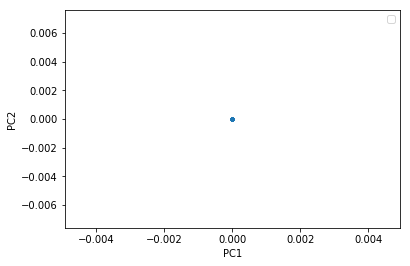

In [108]:
def main():
    #from rdkit import Chem
    #from rdkit.Chem import MACCSkeys
    #spl = Chem.SDMolSupplier('yes1_inhibition.sdf')

    mols = mol.mol_data

    fps = [MACCSkeys.GenMACCSKeys(mol1) for mol1 in mols]
    fpMtx = np.array([fp2arr(fp) for fp in fps])

    plotPCA(fpMtx)

# convert rdkit fingerprint to numpy array
def fp2arr(fp):
    #from rdkit import DataStructs
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


# plot each compound using PCA
def plotPCA(fpMtx):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    res = pca.fit_transform(fpMtx)
    # extract each component
    pc = res.T

    cum_cr = sum(pca.explained_variance_ratio_)
    print("cumulative contribution ratio=%.2f" % cum_cr)

    plt.figure()
    plt.scatter(pc[0], pc[1], marker=".")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.savefig("pca_plot.png")

if __name__ == "__main__":
    main()